In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import zarr
import numpy as np
import sklearn
import tarfile
from tqdm.auto import tqdm
import pickle
import torch
from vip import load_vip
from numpy.linalg import norm
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from ipdb import set_trace as debug
from src.data.utils import zipped_img_generator

In [3]:
device = "cuda:0"
# device = "cpu"

In [4]:
vip = load_vip(device=device).module.to(torch.float16)
vip.eval()
vip.dtype = torch.float16

for param in vip.parameters():
    param.requires_grad = False

In [5]:
oneleg_pickle = (
    "/home/larsankile/furniture-diffusion/data/interim/tmp_oneleg_samples.pkl"
)
lamp_pickle = "/home/larsankile/furniture-diffusion/data/interim/tmp_lamp_samples.pkl"

In [6]:
n_samples = 150
tar_file_oneleg = (
    "/home/larsankile/furniture-diffusion/data/raw/real/image/low/one_leg.tar.gz"
)
tar_file_lamp = (
    "/home/larsankile/furniture-diffusion/data/raw/real/image/low/lamp.tar.gz"
)

In [7]:
def get_samples(n_samples, tar_file):
    imgs = [
        img
        for img in tqdm(
            zipped_img_generator(
                tar_file,
                max_samples=n_samples,
            ),
            total=n_samples,
            desc="Loading images",
        )
    ]

    return imgs

In [8]:
def get_embedding(img):
    img = torch.Tensor(
        np.array([obs["color_image2"] for obs in img["observations"]])
    ).to(device)
    return vip(img.reshape(-1, 3, 224, 224)).detach().cpu().numpy()

In [9]:
def extract_info(samples):
    return [
        dict(
            embeddings=get_embedding(obs),
            skill_index=np.arange(len(obs["skills"]))[np.array(obs["skills"]) == 1],
        )
        for obs in tqdm(samples, desc="Extracting info")
    ]

In [10]:
oneleg_samples = get_samples(n_samples, tar_file_oneleg)
oneleg_embeddings = extract_info(oneleg_samples)

with open(oneleg_pickle, "wb") as f:
    pickle.dump(oneleg_embeddings, f)

Loading images:   0%|          | 0/150 [00:00<?, ?it/s]

Extracting info:   0%|          | 0/150 [00:00<?, ?it/s]

In [11]:
lamp_samples = get_samples(n_samples, tar_file_lamp)
lamp_embeddings = extract_info(lamp_samples)

with open(lamp_pickle, "wb") as f:
    pickle.dump(lamp_embeddings, f)

Loading images:   0%|          | 0/150 [00:00<?, ?it/s]

Extracting info:   0%|          | 0/150 [00:00<?, ?it/s]

In [33]:
def get_diffs(embeddings_list):
    diff_list = []
    longest = 0

    for embeddings in tqdm(embeddings_list, desc="Computing diffs"):
        diffs = [norm(embeddings[-1] - g) for g in embeddings[:-1]]
        diff_list.append(diffs)
        longest = max(longest, len(diffs))

    return diff_list, longest


def get_diffs_skills(embeddings_list, skill_indices_list):
    diff_list = []
    longest = 0

    for embeddings, goal_indices in tqdm(
        zip(embeddings_list, skill_indices_list), desc="Computing diffs"
    ):
        diffs = []
        next_goal_idx = 0
        for i, emb in enumerate(embeddings[:-1]):
            while (
                next_goal_idx < len(goal_indices) and goal_indices[next_goal_idx] <= i
            ):
                next_goal_idx += 1
            if next_goal_idx >= len(goal_indices):
                break
            diff = norm(embeddings[goal_indices[next_goal_idx]] - emb)
            diffs.append(diff)

        diff_list.append(diffs)
        longest = max(longest, len(diffs))
    return diff_list, longest


def interpolate_diffs(diff_list, longest):
    interpolated_diffs = np.zeros((len(diff_list), longest))
    for i, diff in enumerate(diff_list):
        x_old = np.linspace(0, 1, len(diff))
        x_new = np.linspace(0, 1, longest)
        interp_fn = interp1d(
            x_old, diff, kind="linear"
        )  # You can choose other kinds like 'cubic'
        interpolated_diffs[i] = interp_fn(x_new)

    return interpolated_diffs


def plot_diffs(pickle_file, furniture_name, skill_names, len_limits=None, n_traj=None):
    with open(pickle_file, "rb") as f:
        information_list = pickle.load(f)

    # Sort by length of trajectory
    information_list = sorted(information_list, key=lambda x: len(x["embeddings"]))

    if len_limits is not None:
        # Filter out only trajectories of length len_limits[0] < len < len_limits[1]
        information_list = [
            info
            for info in information_list
            if len_limits[0] < len(info["embeddings"]) < len_limits[1]
        ]

    if n_traj is not None:
        information_list = information_list[:n_traj]

    embeddings_list = [info["embeddings"] for info in information_list]
    index_list = np.array([info["skill_index"] for info in information_list])

    diff_list, longest = get_diffs_skills(embeddings_list, index_list)
    # diff_list, longest = get_diffs(embeddings_list)
    interpolated_diffs = interpolate_diffs(diff_list, longest)
    means = np.mean(interpolated_diffs, axis=0)
    stds = np.std(interpolated_diffs, axis=0)

    # _, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10), sharex=True)
    _, ax1 = plt.subplots(1, 1, figsize=(10, 5))

    ax1.plot(means)
    ax1.fill_between(range(len(means)), means - stds, means + stds, alpha=0.3)

    ax1.set_title(f"VIP Feature Distance to Goal for {furniture_name}")

    # Pad shorter 'skills' arrays with zeros and stack into a 2D array
    average_indices = np.mean(index_list, axis=0)

    for i in average_indices:
        ax1.axvline(i, color="red")

    ax1.set_xlabel("Time Step")
    ax1.set_ylabel("Distance to Goal in VIP Feature Space")

    for i, name in zip(average_indices, skill_names):
        ax1.text(i, 0, name, rotation=45, color="red")

    # ax2.imshow(interpolated_diffs, aspect="auto")

    # # Add vertical lines at the places where `imgs[0]['skills']` is 1
    # for i in average_indices:
    #     ax2.axvline(i, color="red")

    ax1.set_xlabel("Time Step")
    ax1.set_ylabel("Trajectory")

Computing diffs: 0it [00:00, ?it/s]

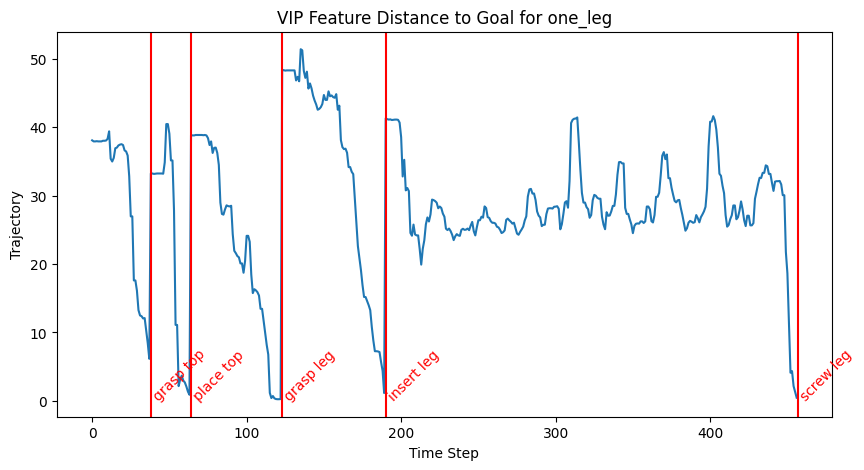

In [34]:
skill_names = ["grasp top", "place top", "grasp leg", "insert leg", "screw leg"]

plot_diffs(oneleg_pickle, "one_leg", skill_names, len_limits=(460, 500), n_traj=1)

Computing diffs: 0it [00:00, ?it/s]

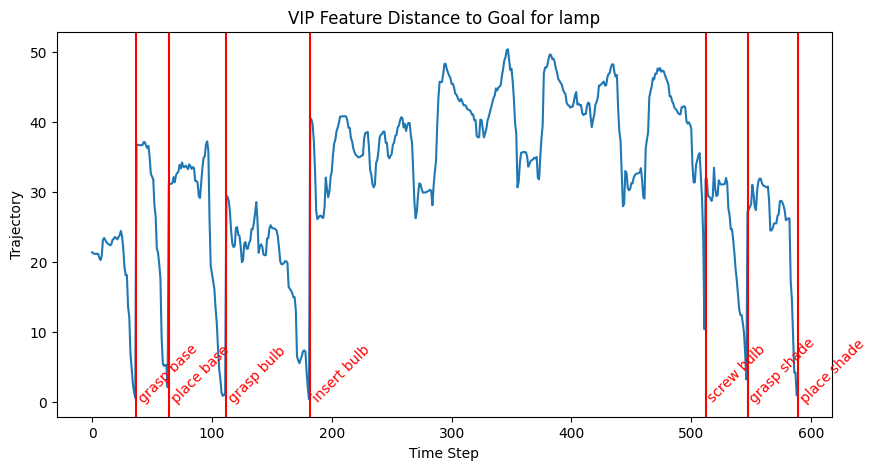

In [30]:
skill_names = [
    "grasp base",
    "place base",
    "grasp bulb",
    "insert bulb",
    "screw bulb",
    "grasp shade",
    "place shade",
]

plot_diffs(lamp_pickle, "lamp", skill_names, len_limits=(600, 700), n_traj=1)

In [15]:
with open(lamp_pickle, "rb") as f:
    information_list = pickle.load(f)

embeddings_list = [info["embeddings"] for info in information_list]
index_list = np.array([info["skill_index"] for info in information_list])

(array([11., 22., 36., 37., 27., 13.,  1.,  2.,  0.,  1.]),
 array([430. , 480.8, 531.6, 582.4, 633.2, 684. , 734.8, 785.6, 836.4,
        887.2, 938. ]),
 <BarContainer object of 10 artists>)

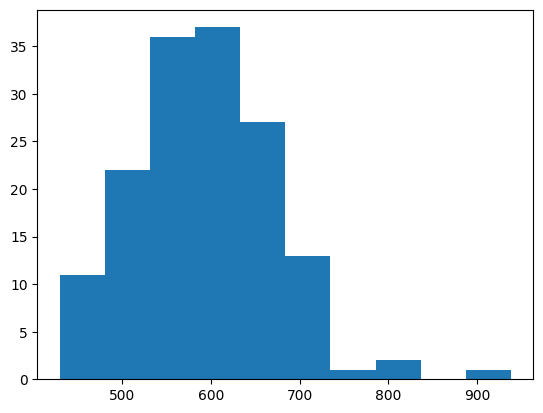

In [16]:
shapes = [e.shape[0] for e in embeddings_list]

# get obs of trajectories shorter than 700
# shorter_than_700 = np.array(shapes) < 700

# embeddings_list = [e for e, s in zip(embeddings_list, shorter_than_700) if s]
# index_list = np.array(index_list)[shorter_than_700]

# shapes = [e.shape[0] for e in embeddings_list]
plt.hist(shapes)

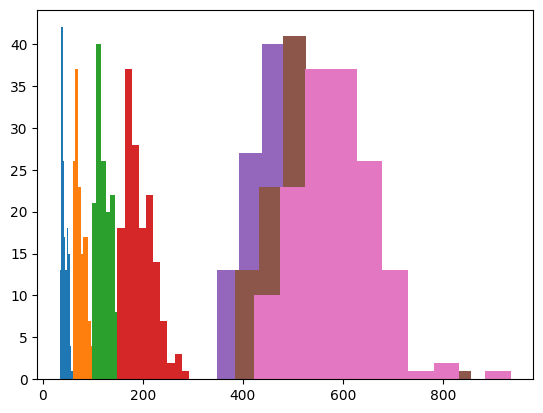

In [17]:
for i in range(index_list.shape[1]):
    plt.hist(index_list[:, i])